In [1]:
from photon_canon.contrib.diffusion_theory import create_integrated_diffusion_approximation
from tqdm.contrib import itertools
from matplotlib import pyplot as plt
import numpy as np
from photon_canon.lut import LUT
from photon_canon.contrib.bio import hemoglobin_mus, model_from_hemoglobin
import functools

lut = LUT(dimensions=['mu_s', 'mu_a'], extrapolate=True, scale=50000)
rng = np.random.default_rng(42)
H, W = 32, 32
wavelengths = np.arange(500, 730, 10)

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jdivers\AppData\Local\Temp\ipykernel_29800\1765810731.py:18: SyntaxWarning: invalid escape sequence '\m'
  fig.suptitle('Maximum $\mu$ value in the range $\lambda \in [500, 720]$ nm')
C:\Users\jdivers\AppData\Local\Temp\ipykernel_29800\1765810731.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set(xlabel='A', ylabel='B', zlabel='Max $\mu_s$')
C:\Users\jdivers\AppData\Local\Temp\ipykernel_29800\1765810731.py:37: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set(xlabel='[THb]', ylabel='sO2', zlabel='Max $\mu_a$')


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

mu_s → max under 30.00 at A=12.17, B=4.09 with value=29.999
mu_a → max under 50.00 at [THb]=26.00, sO2=0.56 with value=49.993


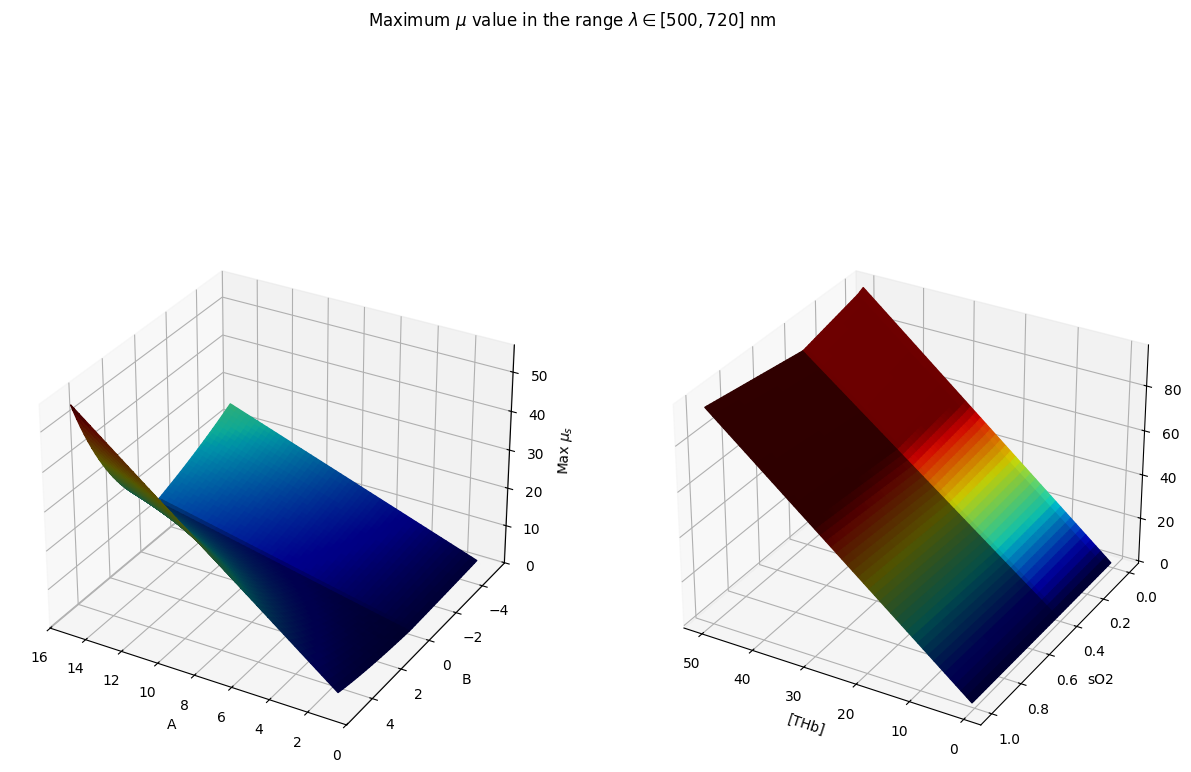

In [2]:
a_array = np.linspace(1, 15, 100)
b_array = np.linspace(-5, 5, 100)
t_array = np.linspace(0.5, 50, 100)
s_array = np.linspace(0, 1, 100)
MUS, MUA = [], []
for a, b in itertools.product(a_array, b_array):
    mus, _, _, = hemoglobin_mus(a, b, 1, 0.5, wavelengths)
    MUS.append(mus)

for t, s in itertools.product(t_array, s_array):
    _, mua, _, = hemoglobin_mus(5, 1, t, s, wavelengths)
    MUA.append(mua)

threshold_mus = 30
threshold_mua = 50

fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection='3d'), figsize=(15, 10))
fig.suptitle('Maximum $\mu$ value in the range $\lambda \in [500, 720]$ nm')

X, Y = np.meshgrid(b_array, a_array)
Z = np.reshape(np.max(MUS, axis=-1), (len(a_array), len(b_array)))
Z_masked = np.ma.masked_where(Z > threshold_mus, Z)
norm = plt.Normalize(vmin=np.min(Z), vmax=np.max(Z))
ax[0].plot_surface(Y, X, Z, facecolors=plt.cm.jet(norm(Z)))
ax[0].set(xlabel='A', ylabel='B', zlabel='Max $\mu_s$')
ax[0].view_init(30, 120)

idx = np.unravel_index(np.nanargmax(Z_masked), Z.shape)
best_a = a_array[idx[1]]
best_b = b_array[idx[0]]
print(f"mu_s → max under {threshold_mus:.2f} at A={best_a:.2f}, B={best_b:.2f} with value={Z[idx]:.3f}")

X, Y = np.meshgrid(s_array, t_array)
Z = np.reshape(np.max(MUA, axis=-1), (len(t_array), len(s_array)))
Z_masked = np.ma.masked_where(Z > threshold_mua, Z)
ax[1].plot_surface(Y, X, Z, facecolors=plt.cm.jet(norm(Z)))
ax[1].set(xlabel='[THb]', ylabel='sO2', zlabel='Max $\mu_a$')
ax[1].view_init(30, 120)

idx = np.unravel_index(np.nanargmax(Z_masked), Z.shape)
best_thb = t_array[idx[1]]
best_so2 = s_array[idx[0]]
print(f"mu_a → max under {threshold_mua:.2f} at [THb]={best_thb:.2f}, sO2={best_so2:.2f} with value={Z[idx]:.3f}")

plt.show()

In [3]:
A = best_a
B = best_b
T = best_thb
S = best_so2

a = np.random.normal(loc=A, scale=A/10, size=(H, W))
b = np.random.normal(loc=B, scale=B/10, size=(H, W))
t = np.random.normal(loc=T, scale=T/10, size=(H, W))
s = np.random.normal(loc=S, scale=S/10, size=(H, W))
Rd = np.zeros((len(wavelengths), H, W))
for i, j in itertools.product(range(H), range(W)):
    Rd[:, i, j] = model_from_hemoglobin(lut, wavelengths, a[i, j], b[i, j], t[i, j], s[i, j]).squeeze()

  0%|          | 0/1024 [00:00<?, ?it/s]

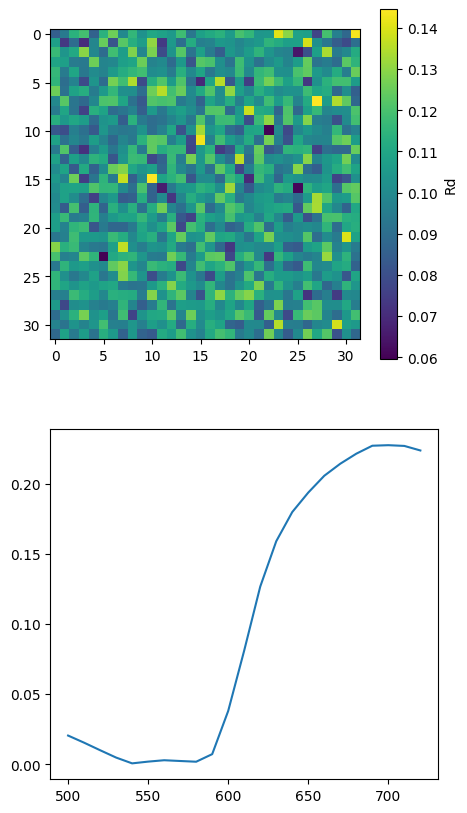

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(5, 10))
im = ax[0].imshow(np.nanmean(Rd, axis=0))
plt.colorbar(im, ax=ax[0], label='Rd')
ax[1].plot(wavelengths, np.nanmean(Rd, axis=(1, 2)))
plt.show()

In [5]:
from hsdfmpm.hsdfm.fit import fit_volume

ready_model = functools.partial(model_from_hemoglobin, lut, wavelengths)
bounds = np.array([[0, 0, 0, 0], [np.inf, np.inf, np.inf, 1]])
guess = np.array([0, 0, 0, 0])
param_image, score = fit_volume(model=ready_model, bounds=bounds, volume=Rd, x0=guess)
af, bf, tf, sf = param_image

  0%|          | 0/1024 [00:00<?, ?it/s]

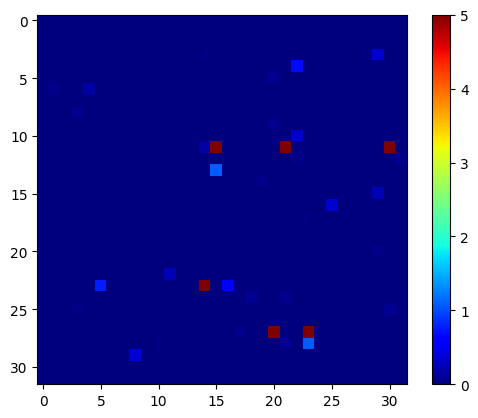

In [6]:
plt.imshow(np.clip(score, a_min=0, a_max=5), cmap='jet')
plt.colorbar()
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jdivers\AppData\Local\Temp\ipykernel_29800\2215409426.py:10: SyntaxWarning: invalid escape sequence '\l'
  ax[0].set(title='Reflectance', xlabel='$\lambda$ (nm)', ylabel='R')
C:\Users\jdivers\AppData\Local\Temp\ipykernel_29800\2215409426.py:13: SyntaxWarning: invalid escape sequence '\m'
  ax[1].plot(wavelengths, mu_s, label='$\mu_s$')
C:\Users\jdivers\AppData\Local\Temp\ipyke

  0%|          | 0/1024 [00:00<?, ?it/s]

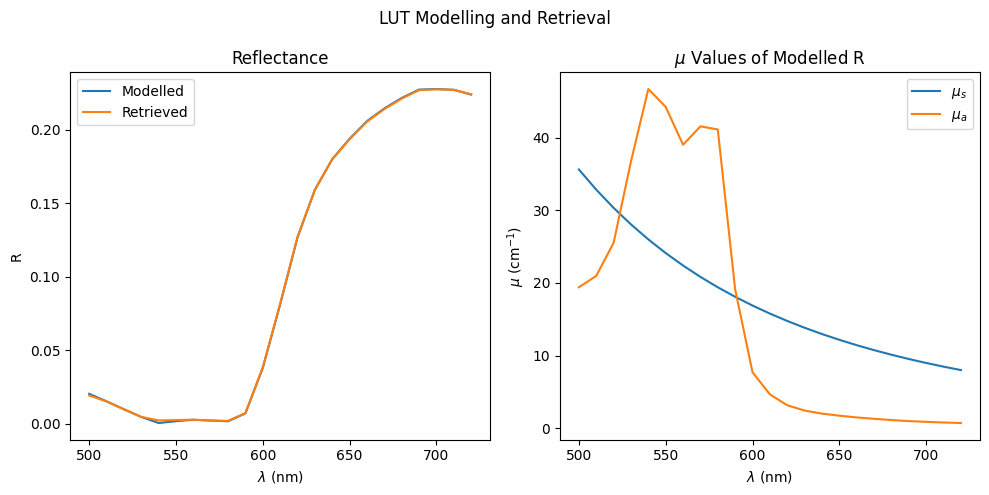

In [7]:
mu_s, mu_a, _ = hemoglobin_mus(best_a, best_b, best_thb, best_so2, wavelengths)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('LUT Modelling and Retrieval')

ax[0].plot(wavelengths, np.nanmean(Rd, axis=(1, 2)) , label='Modelled')
Re = np.zeros((len(wavelengths), H, W))
for i, j in itertools.product(range(H), range(W)):
    Re[:, i, j] = model_from_hemoglobin(lut, wavelengths, af[i, j], bf[i, j], tf[i, j], sf[i, j]).squeeze()
ax[0].plot(wavelengths, np.nanmean(Re, axis=(1, 2)), label='Retrieved')
ax[0].set(title='Reflectance', xlabel='$\lambda$ (nm)', ylabel='R')
ax[0].legend()

ax[1].plot(wavelengths, mu_s, label='$\mu_s$')
ax[1].plot(wavelengths, mu_a, label='$\mu_a$')
ax[1].set(title='$\mu$ Values of Modelled R', xlabel='$\lambda$ (nm)', ylabel='$\mu$ (cm$^{-1}$)')
ax[1].legend()

plt.tight_layout()
plt.show()

In [13]:
def percent_error(o, e):
    return 100 * np.nanmean((o - e) / e)

a_error = percent_error(af, a)
b_error = percent_error(bf, b)
t_error = percent_error(tf, t)
s_error = percent_error(sf, s)

print(f'Errors -- A: {a_error:0.2f}%, B: {b_error:0.2f}%,, THb: {t_error:0.2f}%, sO2: {s_error:0.2f}%')

Errors -- A: -2.16%, B: -3.60%,, THb: -2.98%, sO2: -1.74%


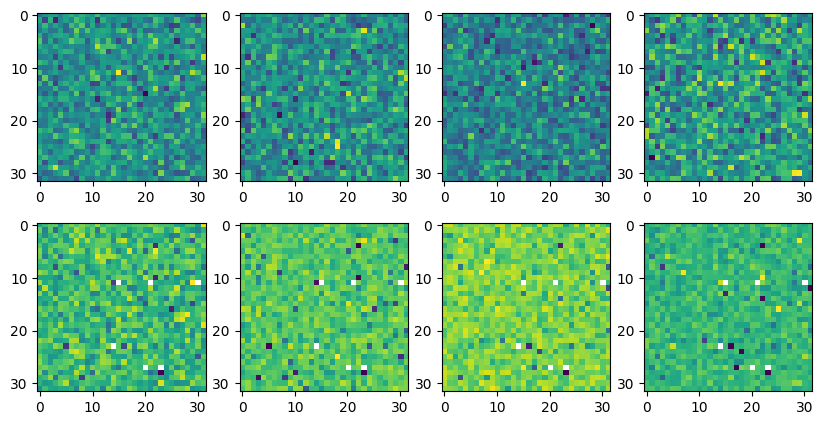

In [14]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
ax[0, 0].imshow(a)
ax[1, 0].imshow(af)
ax[0, 1].imshow(b)
ax[1, 1].imshow(bf)
ax[0, 2].imshow(t)
ax[1, 2].imshow(tf)
ax[0, 3].imshow(s)
ax[1, 3].imshow(sf)
plt.show()